# Productionize Big Data with `Dash` and `Vaex`

## Intro to `Vaex`

26 - August - 2020

### Demo data: New York Taxi Dataset (2009 - 2015)

The original data can be found at: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [ ]:
import vaex

import numpy as np

import plotly.express as px

import warnings; warnings.simplefilter('ignore')

### Main concepts behind `vaex`:
 - Memory mapping
 - Lazy evaluations
 - Expression system ("virtual columns")
 - High performance, out-of-core algorithms

### Memory mapping

In [ ]:
!du -h /data/yellow*

Memory mapping allows instant access to the data!

In [ ]:
%%time
df = vaex.open('/data/yellow_taxi_2009_2015_f32.hdf5')
df

Note: Vaex is cloud-friendly!

You can stream your data directly from S3 (GS and AS support coming soon!), and download only the portions you _really_ need:
```
df = vaex.open('s3://vaex/taxi/yellow_taxi_2015_f32s.hdf5?anon=true')
```

### Lazy evaluations, Expressions, "virtual" columns

In Vaex, a single column is called an _expression_:

In [ ]:
%%time
df.tip_amount

Defining new columns takes no memory, since they are only _expressions_:

In [ ]:
%%time
df['tip_percentage'] = df.tip_amount / df.total_amount * 100
df.tip_percentage

Peaking at the data is instant!

In [ ]:
df

Eager execution is _fast!_

In [ ]:
df.tip_percentage.mean(progress='widget')

Filtering creates a shallow copy of a DataFrame. The data itself is not copied, but only a reference is made, thus no RAM is wasted:

In [ ]:
df_filtered = df[df.total_amount > 0]
df_filtered.tip_percentage.mean(progress='widget')

### Selections: on-the-fly filtering

Performance boost: evaluations using on-the-fly filtering does only one pass over the data!

In [ ]:
df.mean(expression=df.tip_percentage, selection=df.total_amount>0, progress='widget')

Specifying selections: the `select` method

In [ ]:
df.select(df.total_amount>0)
df.mean(expression=df.tip_percentage, selection=True, progress='widget')

### High performance, efficient algorithms - tailored for data science

In [ ]:
rows, columns = df.shape
print(f'Number of rows: {rows:,}')
print(f'Number of columns: {columns}')

### Efficient methods for data science uses

Example: `value_counts()`

In [ ]:
df.passenger_count.value_counts(progress='widget')

### Fast GroupBy / Aggregations

In [ ]:
%%time
df_grouped = df.groupby(by=df.passenger_count).agg({'fare_amount': 'mean',
                                                     'tip_amount': 'mean'})

df_grouped

### Incredibly fast Join operations

In [ ]:
%%time
df_joined = df.join(other=df_grouped, on=df.passenger_count, rsuffix='_agg')
df_joined

## Where `vaex` trully shines is computing statistics on N-dimensional grids

### Exploring `df.count()`

- #### 0-dimensions: single statistic (e.g. count, mean, standard deviation, etc..)

In [ ]:
# Standard deviation
df.count(progress='widget')

- #### 1-dimension: histograms

In [ ]:
counts_total_amount = df.count(binby=df.total_amount, limits=[0, 100], shape=32, progress='widget')
counts_total_amount

In [ ]:
x_arr = np.linspace(0, 100, 32)
px.bar(x=x_arr, y=counts_total_amount)

- 2-dimensions: heatmaps

In [ ]:
counts_2d = df.count(binby=[df.pickup_longitude, df.pickup_latitude], 
                     shape=256, 
                     limits=[[-74.05, -73.75], [40.58, 40.90]],
                     progress='widget')
counts_2d

In [ ]:
# We can also use Plotly of course!
px.imshow(np.log1p(counts_2d.T), origin='lower')

The `count` method generalizes to N-dimensions.

## The Goal for today...

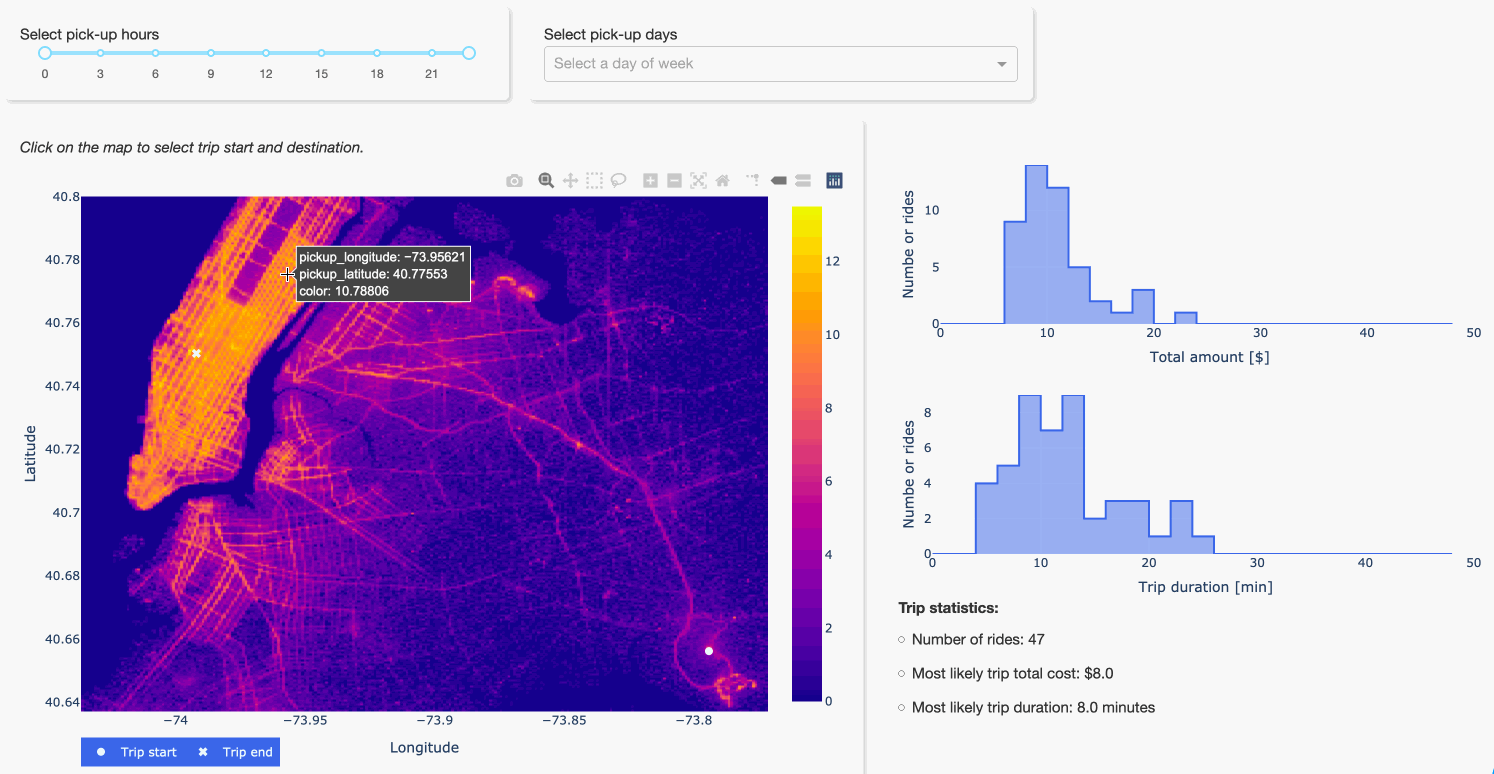